Prepare the data in 2 different ways. 
1. Alzheimer Detection: Whether the patient has the alzhiemer or not (non vs all other categories) 
2. Alzheimer Classifier: Define what stage the patient is in the alzheimer. 

The models that are going to be tested here are 
1. PCA for Alzheimer Detection
2. LDA for Alzheimer Detection
3. SVM for Alzheimer Detection and Alzheimer Classifier
4. CNN for Alzheimer Detection(VGG16) and Alzheimer Classifier(EfficientNetB0)

Download the Image files from https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data and specify the Folders in your code

In [20]:
#Set up the environment and upload the data
from sklearn.preprocessing import StandardScaler
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep 
from tqdm.notebook import tqdm
import os
sns.set()

First, download the data from Kaggle [https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset]

In [21]:
#Dataset that should go with Alzheimer label
very_mild = glob(r"..\Dataset\Very_Mild_Demented\*")
mild = glob(r"..\Dataset\Mild_Demented\*")
moderate = glob(r"..\Dataset\Moderate_Demented\*")

#Dataset without Alzheimer
non = glob(r"..\Dataset\Non_Demented\*")

..\Dataset\Non_Demented\non_10.jpg
One of the data in Non Alzheimer Folder
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

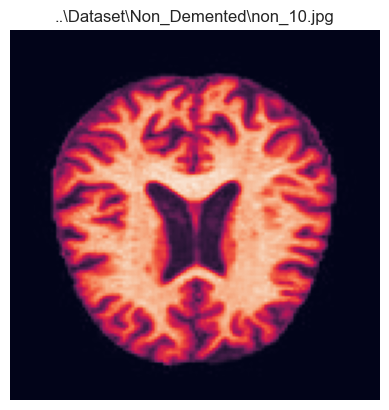

In [22]:
print(non[1])
def view_image(directory):
    img = mpimg.imread(directory)
    plt.imshow(img)
    plt.title(directory)
    plt.axis('off')
    print(f'Image shape:{img.shape}')
    return img

print('One of the data in Non Alzheimer Folder')
view_image(non[1])

Alzheimer Patient's Brain
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

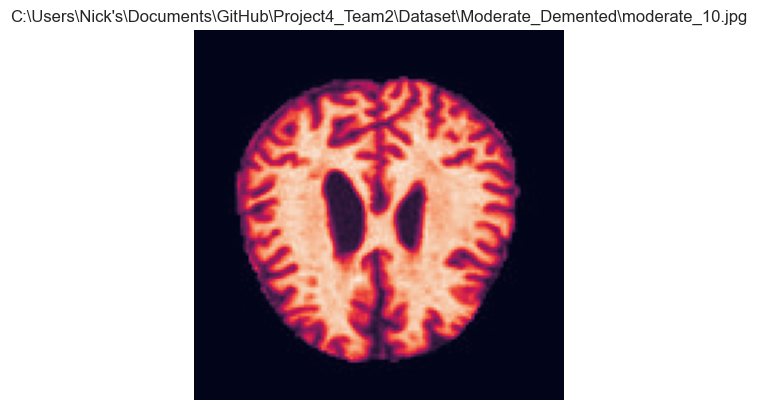

In [9]:
print('Alzheimer Patient\'s Brain')
view_image(moderate[1])

## 3. Testing and Analysis
## 3.1 Alzheimer Detection Models
### PCA for Alzheimer Detection

Number of components explaining 80% variance: 174
[[ -3.90013305   6.59213095  -6.29385432 ...  -0.78990606  -1.26022245
    0.48420975]
 [ 14.67936274  12.56926166  15.36512655 ...  -0.65785547   1.06499197
   -0.48738282]
 [ 22.0546406   -3.38434915  -2.79926946 ...   1.59934588   0.89635122
    1.12264409]
 ...
 [-11.77959589 -18.32081331  -1.83193535 ...  -0.47832713  -1.04019003
   -1.04522844]
 [  0.07522262  17.70887941  -3.35919601 ...  -0.79164826  -0.64174341
    0.59814657]
 [ 13.69272257   6.7291222   -6.60012193 ...  -0.14778661  -0.0644787
   -0.38302716]]


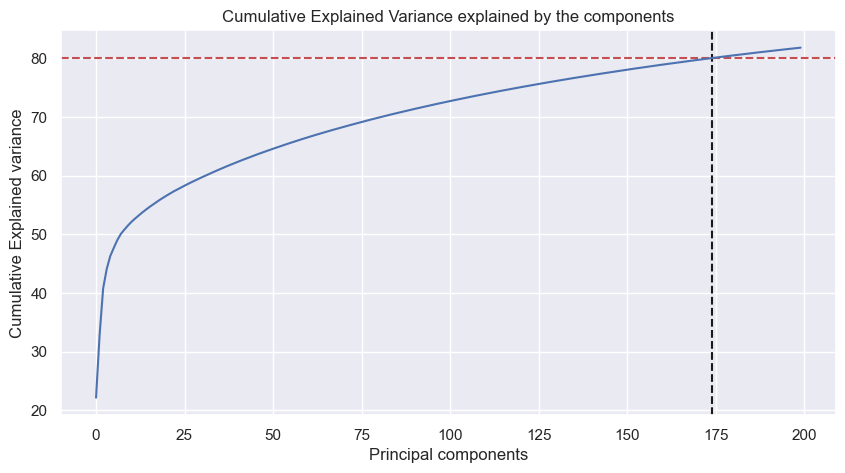

In [10]:
def extract_feature(dir_path):
    img = mpimg.imread(dir_path)
    img = img / 255.0  # normalize pixel values
    img = resize(img, (128, 128, 3))  # convert all images to (128x128x3)
    img = np.reshape(img, (128, 384))
    return img

non_ALZ = [extract_feature(filename) for filename in non]
vmild_ALZ = [extract_feature(filename) for filename in very_mild]
mild_ALZ = [extract_feature(filename) for filename in mild]
moderate_ALZ = [extract_feature(filename) for filename in moderate]
ALZ = vmild_ALZ + mild_ALZ + moderate_ALZ

#for PCA
all_data = np.concatenate((np.array(non_ALZ),np.array(ALZ)))
#print(all_data)
all_data = all_data.reshape(all_data.shape[0], np.product(all_data.shape[1:]))

scaler = StandardScaler()
scaler.fit(all_data)

#standardize data to 0 mean and unit variance
X = scaler.transform(all_data)

#split the data 
from sklearn.model_selection import train_test_split
y = [0] * len(non_ALZ) + [1] * len(ALZ)
X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size=0.2)

scala = preprocessing.StandardScaler()
#Compressing the images into two dimensions using PCA
pca = decomposition.PCA(200)
X_proj = pca.fit_transform(X_train)

#let's first see which principal component works better
#scree plot but cumulative
# Getting the cumulative variance 
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100 #100 is multiplied for percentage
 
# How many PCs explain 90% of the variance?
k = np.argmax(var_cumu>80)
print("Number of components explaining 80% variance: "+ str(k)) #I guess, I will have to use 160 axis
#print("\n")
 
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=80, color="r", linestyle="--")
ax = plt.plot(var_cumu)

print(X_proj)

From looking at the above, PCA will differentiate the dataset into two, a brain suffering from alzheimer or not. However, to have at least 80% accuracy of differentiation, it requires 174 principal components. This means that to differentiate the data with 80% accuracy, we will need to make a model that has 174 different axis in the data.

### LDA Model 

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_train_LDA = lda.fit_transform(X_train, y_train)
X_test_LDA = lda.transform(X_test)
accuracy = lda.score(X_test, y_test)
print(accuracy*100, '% accuracy (testing data)' )
accuracy_train = lda.score(X_train, y_train)
print(accuracy_train*100, '% accuracy (training data)')

89.0625 % accuracy (testing data)
99.98046875 % accuracy (training data)


First time when I saw the performance of the LDA(Linear Discriminant Analysis) model, I was suprised to see the performance of the model on the training data is so high. as well as the performance on the testing data is also significant. This gave me a lot of confidence about the data as it seems to be very well taken with MRI. 

### SVM for Alzheimer Detection

In [12]:
#List where arrays shall be stored
resized_image_array=[]
#List that will store the answer if an image is female (0) or male (1)
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) #the data is just black to white 

#Iterate over pictures and resize them to 256 by 256
def resizer(image_directory):
    for file in image_directory: #tried with os.listdir but could work with os.walk as well
        img = Image.open(file) #just putting image_directory or file does not work for google colab, interesting. 
        #preserve aspect ratio
        img = img.resize(new_size)
        array_temp = np.array(img)
        shape_new = width*height
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        if image_directory == non:
            resized_image_array_label.append(0)
        else:
            resized_image_array_label.append(1)

ALZ = very_mild + mild + moderate
resizer(non)
resizer(ALZ)



In [13]:
print(len(non))
print(len(ALZ)) #data are well transformed. Let's conduct SVM
print(len(resized_image_array))
print(resized_image_array[1])

#split the data to test and training
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)


3200
3200
6400
[0 0 0 ... 0 0 0]


In [14]:
#train SVM model
#from sklearn import svm
clf = svm.SVC(kernel = 'linear')
clf.fit(train_x, train_y)
#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred)) #The training seems to be done with high accuracy on training data.

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred)) #Having high training data accuracy might mean that it is having some overfitting

Accuracy :  1.0
Precision :  1.0
Recall :  1.0
f1 :  1.0
Confusion matrix : [[2566    0]
 [   0 2554]]
Accuracy :  0.97734375
Precision :  0.9843014128728415
Recall :  0.9705882352941176
f1 :  0.9773967264224473
Confusion matrix : [[624  10]
 [ 19 627]]


In [15]:
#Train a SVM using polynomial kernel with degree of 2
clf = svm.SVC(kernel = 'poly', degree = 2)
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

Accuracy :  0.8927734375
Precision :  0.8863198458574181
Recall :  0.9005481597494127
f1 :  0.89337735482618
Confusion matrix : [[2271  295]
 [ 254 2300]]
Accuracy :  0.85625
Precision :  0.841715976331361
Recall :  0.8808049535603715
f1 :  0.8608169440242057
Confusion matrix : [[527 107]
 [ 77 569]]


In [16]:
#Train a SVM using RBF kernel
clf = svm.SVC(kernel = 'rbf')
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

Accuracy :  0.8671875
Precision :  0.8485863095238095
Recall :  0.8931088488645262
f1 :  0.870278519648989
Confusion matrix : [[2159  407]
 [ 273 2281]]
Accuracy :  0.8375
Precision :  0.8084507042253521
Recall :  0.8885448916408669
f1 :  0.8466076696165192
Confusion matrix : [[498 136]
 [ 72 574]]


SVM Model for different Alzheimer category 

In [17]:
#List where arrays shall be stored
resized_image_array=[]
#List that will store the answer if an image is female (0) or male (1)
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) #the data is just black to white 

#Iterate over pictures and resize them to 256 by 256
def resizer(image_directory):
    for file in image_directory: #tried with os.listdir but could work with os.walk as well
        img = Image.open(file) #just putting image_directory or file does not work for google colab, interesting. 
        #preserve aspect ratio
        img = img.resize(new_size)
        array_temp = np.array(img)
        shape_new = width*height
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        if image_directory == non:
            resized_image_array_label.append(0)
        elif image_directory == very_mild:
            resized_image_array_label.append(1)
        elif image_directory == mild:
            resized_image_array_label.append(2)
        else:
            resized_image_array_label.append(3)

resizer(non)
resizer(very_mild)
resizer(mild)
resizer(moderate)

#split the data to test and training
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)

#train SVM model
#from sklearn import svm
clf = svm.SVC(kernel = 'linear')
clf.fit(train_x, train_y)
#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

Accuracy :  1.0
Accuracy :  0.99140625


In [18]:
#Train a SVM using polynomial kernel with degree of 2
clf = svm.SVC(kernel = 'poly', degree = 2)
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))


Accuracy :  0.868359375
Accuracy :  0.79375


In [19]:
#Train a SVM using RBF kernel
clf = svm.SVC(kernel = 'rbf')
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

Accuracy :  0.809765625
Accuracy :  0.73203125
